In [1]:
import gym
import tensorflow as tf
import numpy as np

/home/gopi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
# from baselines import deepq
import balance_bot

In [8]:
env = gym.make("balancebot-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'balance_bot.envs.balancebot_env.BalancebotEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


In [8]:
env.close()

In [9]:
env.reset()
rewards = []
# env.step(env.action_space.sample())
for _ in range(100):
#     env.render(mode='human')
    state, reward, done , info = env.step(env.action_space.sample())
    rewards.append(reward)
    if done:
#         print(rewards[:10])
        rewards = []
        env.reset()
        
env.close()

In [10]:
state

array([-0.21342179, -2.00501655, -5.5       ])

In [11]:
env.action_space

Discrete(9)

In [12]:
class QNetwork:
    def __init__(self , learning_rate=0.001,
                state_size=3, 
                action_size=9,
                hidden_size=16,
                name='QNetwork'):
        # state inputs to the Q-Network
        # https://stackoverflow.com/questions/35919020/whats-the-difference-of-name-scope-and-a-variable-scope-in-tensorflow
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to latte choose the Q-Value for the action
            self.actions_ = tf.placeholder(tf.int32 , [None] , name="actions") # action value is 0 or 1 , one_hot take int values
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None] , name="targetQ")
            
            # ReLU hidden layer
            # See tf.layers.dense() tf.contrib.layers.fully_connected()
#             self.fc1 = tf.contrib.layers.fully_connected(self.inputs_ , hidden_size , weights_initializer=ttf.contrib.layers.xavier_initializer ,weights_regularizer=None) # activation relu applied by default 
#             self.fc2 = tf.contrib.layers.fully_connected(self.fc1 , hidden_size, weights_initializer=tf.contrib.layers.xavier_initializer ,weights_regularizer=None)
            self.fc1 = tf.layers.dense(self.inputs_ , hidden_size , activation=tf.nn.relu , kernel_initializer=tf.contrib.layers.xavier_initializer() ) #, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
            self.hc1 = tf.layers.dense(self.fc1 , hidden_size , activation=tf.nn.relu , kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.layers.dense(self.hc1, hidden_size , activation=tf.nn.relu , kernel_initializer=tf.contrib.layers.xavier_initializer()) # , kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
            # Linear output layer
#             self.output = tf.contrib.layers.fully_connected(self.fc2 , action_size , activation_fn=None)
            self.output = tf.layers.dense(self.fc2 , action_size , activation=None)
            
            
            ## Train with loss (targetQ - Q)^2
            # output has length 9, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output , one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            

In [13]:
from collections import deque
class Memory():
    def __init__(self , max_size= 1000):
        self.buffer = deque(maxlen = max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        index = np.random.choice(np.arange(len(self.buffer)),
                                size = batch_size,
                                replace = False)
        return [self.buffer[idx] for idx in index]

In [38]:
train_episodes = 500          # max number of episodes to learn from
max_steps = 400              # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 0.3            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 50000            # memory capacity
batch_size = 64                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [39]:
tf.reset_default_graph()
mainQN = QNetwork(name="main" , hidden_size=hidden_size, learning_rate=learning_rate)

In [16]:
env.reset()

# Take one random step to get the pole and cart moving
state , reward, done, info = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for i in range(pretrain_length):
    #env.render()
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    
    else:
        # Add experience to memory
        memory.add((state,action, reward , next_state))
        state = next_state

In [40]:
# Now train with experience

saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    decay_step = 0
    for episode in range(1, train_episodes):
        total_reward = 0
        step =0
        while step < max_steps:
            decay_step +=1
#             env.render(mode='human')
            
            # Explore or Exploit
            explore_prob = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*decay_step)
            
            if explore_prob > np.random.rand() : # return [0,1)
                # random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_:state.reshape((1, *state.shape))}
                Q_pred = sess.run(mainQN.output , feed_dict= feed)
                action = np.argmax(Q_pred)
                
            # Take action, get new_state and reward
            next_state , reward , done, _ = env.step(action)
            
            total_reward +=reward
            
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                step = max_steps
                
                print('Episode: {}'.format(episode),
                     'Total reward: {}'.format(total_reward),
                     'Training loss: {:.4f}'.format(loss),
                     'Explore Prob: {:.4f}'.format(explore_prob))
                
                rewards_list.append((episode , total_reward))
                
                # Add experience to memory
                memory.add((state, action,reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                step +=1
                
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states_mb = np.array([each[0] for each in batch])
            actions_mb = np.array([each[1] for each in batch])
            rewards_mb = np.array([each[2] for each in batch])
            next_states_mb = np.array([each[3] for each in batch])
            
            ### TRAINING NETWORK
            targetQs = sess.run(mainQN.output, feed_dict={mainQN.inputs_:next_states_mb})
            
            # Set target_Qs to 0 for states where episode ends 
            episode_ends = (next_states_mb==np.zeros(states_mb[0].shape)).all(axis=1)
            
            targetQs[episode_ends]  = (0, 0 , 0 , 0 , 0 , 0, 0 ,0 ,0 )
            
            targets = rewards_mb + gamma*np.max(targetQs, axis=1)
            
            loss , _ = sess.run([mainQN.loss , mainQN.optimizer],
                               feed_dict={mainQN.inputs_:states_mb,
                                         mainQN.targetQs_: targets,
                                         mainQN.actions_: actions_mb})
            
            
    
    saver.save(sess, "checkpoints/cartpole{}.ckpt".format(train_episodes))

Episode: 1 Total reward: -1.9304019096194391 Training loss: 0.0498 Explore Prob: 0.2979
Episode: 2 Total reward: 1.6517773706246033 Training loss: 0.1089 Explore Prob: 0.2962
Episode: 3 Total reward: 2.3206454823045255 Training loss: 0.9538 Explore Prob: 0.2932
Episode: 4 Total reward: -0.2071199192477486 Training loss: 7.6148 Explore Prob: 0.2918
Episode: 5 Total reward: 3.5944633554509076 Training loss: 13.3642 Explore Prob: 0.2896
Episode: 6 Total reward: 1.4241389814703709 Training loss: 321.7290 Explore Prob: 0.2879
Episode: 7 Total reward: 4.050348837807045 Training loss: 35.2715 Explore Prob: 0.2855
Episode: 8 Total reward: 1.2340351485112924 Training loss: 136.7582 Explore Prob: 0.2838
Episode: 9 Total reward: 0.41294598280880934 Training loss: 1490.4381 Explore Prob: 0.2823
Episode: 10 Total reward: -0.4667434834728469 Training loss: 35.2275 Explore Prob: 0.2790
Episode: 11 Total reward: 2.991322137921856 Training loss: 1034.0236 Explore Prob: 0.2770
Episode: 12 Total reward: 

Episode: 95 Total reward: 2.181124789651172 Training loss: 0.1855 Explore Prob: 0.1423
Episode: 96 Total reward: 3.039610404422819 Training loss: 0.2441 Explore Prob: 0.1413
Episode: 97 Total reward: 1.433034967479469 Training loss: 2.2274 Explore Prob: 0.1405
Episode: 98 Total reward: 1.9552866662357138 Training loss: 0.1887 Explore Prob: 0.1397
Episode: 99 Total reward: 1.586182687703453 Training loss: 0.5400 Explore Prob: 0.1389
Episode: 100 Total reward: 2.5664580371268264 Training loss: 0.1517 Explore Prob: 0.1380
Episode: 101 Total reward: 2.1217924640221706 Training loss: 0.5240 Explore Prob: 0.1372
Episode: 102 Total reward: 0.1491354532856637 Training loss: 0.3576 Explore Prob: 0.1365
Episode: 103 Total reward: 1.1181994834697901 Training loss: 0.2783 Explore Prob: 0.1358
Episode: 104 Total reward: 2.504545494605659 Training loss: 0.8302 Explore Prob: 0.1350
Episode: 105 Total reward: 8.094847182770206 Training loss: 0.1709 Explore Prob: 0.1328
Episode: 106 Total reward: 3.729

Episode: 194 Total reward: -1.3419055896778365 Training loss: 154127856.0000 Explore Prob: 0.0437
Episode: 195 Total reward: -1.4634029262819213 Training loss: 71737904.0000 Explore Prob: 0.0436
Episode: 196 Total reward: -1.5626652286515221 Training loss: 328782144.0000 Explore Prob: 0.0434
Episode: 197 Total reward: -1.1381883777914967 Training loss: 2299502592.0000 Explore Prob: 0.0433
Episode: 198 Total reward: -1.491697335480214 Training loss: 174475120.0000 Explore Prob: 0.0432
Episode: 199 Total reward: -1.4755767520191987 Training loss: 6299365376.0000 Explore Prob: 0.0431
Episode: 200 Total reward: -1.1553661485889277 Training loss: 2214041088.0000 Explore Prob: 0.0429
Episode: 201 Total reward: -1.3339853276187457 Training loss: 122427976.0000 Explore Prob: 0.0428
Episode: 202 Total reward: -1.4291609553191216 Training loss: 165366368.0000 Explore Prob: 0.0427
Episode: 203 Total reward: -1.2523274866550627 Training loss: 2802337280.0000 Explore Prob: 0.0426
Episode: 204 Total

Episode: 279 Total reward: 2.8013879497124328 Training loss: 9975637.0000 Explore Prob: 0.0320
Episode: 280 Total reward: 10.043863854147887 Training loss: 5243420.0000 Explore Prob: 0.0317
Episode: 281 Total reward: 6.112169893883521 Training loss: 82644432.0000 Explore Prob: 0.0315
Episode: 282 Total reward: 6.615002681978318 Training loss: 10712052.0000 Explore Prob: 0.0312
Episode: 283 Total reward: 11.79085299081563 Training loss: 602441344.0000 Explore Prob: 0.0309
Episode: 284 Total reward: 7.1551159520133 Training loss: 3233838.0000 Explore Prob: 0.0307
Episode: 285 Total reward: 13.144218470444756 Training loss: 4077110.5000 Explore Prob: 0.0303
Episode: 286 Total reward: 11.464669684986792 Training loss: 355891712.0000 Explore Prob: 0.0300
Episode: 287 Total reward: 6.587616790414951 Training loss: 2651339.0000 Explore Prob: 0.0298
Episode: 288 Total reward: -1.4755767520191987 Training loss: 48287636.0000 Explore Prob: 0.0297
Episode: 289 Total reward: -1.1625091813427806 Tr

Episode: 365 Total reward: -2.611863456168622 Training loss: 356788.1250 Explore Prob: 0.0249
Episode: 366 Total reward: -2.823855494557991 Training loss: 10059250.0000 Explore Prob: 0.0249
Episode: 367 Total reward: -2.611196785961284 Training loss: 625955.7500 Explore Prob: 0.0248
Episode: 368 Total reward: -2.7321424283040967 Training loss: 29994352.0000 Explore Prob: 0.0248
Episode: 369 Total reward: -2.8193656452451696 Training loss: 443037.6875 Explore Prob: 0.0247
Episode: 370 Total reward: -2.611196785961284 Training loss: 545037.7500 Explore Prob: 0.0247
Episode: 371 Total reward: -2.694812561594278 Training loss: 352206.9375 Explore Prob: 0.0246
Episode: 372 Total reward: -2.703754591255694 Training loss: 328037.3750 Explore Prob: 0.0246
Episode: 373 Total reward: -2.857550135094965 Training loss: 391503.4375 Explore Prob: 0.0245
Episode: 374 Total reward: -2.687004991321505 Training loss: 336376.2500 Explore Prob: 0.0245
Episode: 375 Total reward: -2.990159052394393 Training

Episode: 452 Total reward: 1.111713788581437 Training loss: 104444.4062 Explore Prob: 0.0184
Episode: 453 Total reward: 2.100765763498919 Training loss: 364753.9688 Explore Prob: 0.0183
Episode: 454 Total reward: 1.4740193241633655 Training loss: 900996.7500 Explore Prob: 0.0182
Episode: 455 Total reward: 1.7843435620660677 Training loss: 117538.2031 Explore Prob: 0.0181
Episode: 456 Total reward: 3.17030583493334 Training loss: 379133.0312 Explore Prob: 0.0181
Episode: 457 Total reward: 2.8644180096804046 Training loss: 103390.3125 Explore Prob: 0.0180
Episode: 458 Total reward: 3.3958867571480944 Training loss: 101369.5625 Explore Prob: 0.0179
Episode: 459 Total reward: 2.9621279244582452 Training loss: 194869.7031 Explore Prob: 0.0179
Episode: 460 Total reward: 3.277993872713315 Training loss: 68811.2188 Explore Prob: 0.0178
Episode: 461 Total reward: 2.5662687082796345 Training loss: 47597.6250 Explore Prob: 0.0178
Episode: 462 Total reward: 2.935259948369405 Training loss: 78176.0

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Reward')

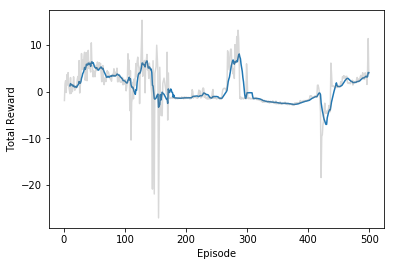

In [42]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [37]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
#             env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
#                 print('Episode: {}'.format(ep),
#                      'Total reward: {}'.format(total_reward),
#                      'Training loss: {:.4f}'.format(loss),
#                      'Explore Prob: {:.4f}'.format(explore_prob))
                

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole500.ckpt


In [11]:
env.close()